In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from energyflow.archs import EFN
from energyflow.utils import data_split

In [2]:
def read_data(file_path):
    data_file = open(file_path)
    lno = 0
    pTvals = []
    etavals = []
    phivals = []
    tvals = []
    events_input=[]
    events_target=[]
    data = []

    for line in data_file:
        lno+=1
        if (lno > 1000000000):
            break
        # enumber = int(line.split()[0])
        isprime = int(line.split()[1])
        E = float(line.split()[2])
        px = float(line.split()[3])
        py = float(line.split()[4])
        pz = float(line.split()[5])
        t = float(line.split()[6])
        
        pT = math.sqrt( px**2 + py**2 )
        p = math.sqrt( px**2 + py**2 + pz**2 )
        
        if (pz > 0):    
            eta = math.acosh(p / pT)
        else:
            eta = -math.acosh(p / pT)
        phi = math.atan( py / px )
        
        if (isprime==1):
            pTvals += [pT]
            etavals += [eta]
            phivals += [phi]
            tvals += [t]
            data += [[pT,eta,phi,t]]
        if (isprime==0):
            events_target += [[t]] 
            if (lno > 1):
                events_input += [data]
            data=[]

    events_input += [data]

    return events_input, events_target



In [3]:
def zero_padding(raw_data, max_num):

    input_zp = np.zeros([max_num,40,4])

    for i in range(0, max_num):
        for j in range(min(40,len(raw_data[i]))):
            input_zp[i,j,:] = raw_data[i][j]
        np.random.shuffle(input_zp[i,:,:])

    return input_zp

In [4]:
def normalization(input, target, max_num):

    pT_weighted_time = []

    for jet in input:
        mask = jet[:,0] > 0
        yphi_avg = np.average(jet[mask,1:3], weights=jet[mask,0], axis=0)
        jet[mask,1:3] -= yphi_avg
        
        t_avg = np.average(jet[mask,3], weights=jet[mask,0], axis=0)
        pT_weighted_time += [[t_avg]]
        jet[mask,3] /= t_avg
        jet[mask,3] -= 1
        jet[mask,0] /= jet[:,0].sum()

    target = np.array(target[:max_num])
    target_scaled = target / pT_weighted_time - 1

    return pT_weighted_time, input, target_scaled

In [5]:
def preprocessing(input_path_list, max_num):

    data_input_dict = {}
    data_label_dict = {}
    data_pTweighted_dict = {}

    for key, data_path in enumerate(input_path_list):
        
        raw_input, raw_label = read_data(data_path)
        input_zp = zero_padding(raw_input, max_num)
        pTweighted_time, input_scaled, label_scaled = normalization(input_zp, raw_label, max_num)

        data_input_dict["input"+data_path] = input_scaled
        data_label_dict["label"+data_path] = label_scaled
        data_pTweighted_dict["pTweighted"+data_path] = pTweighted_time

    return data_pTweighted_dict, data_input_dict, data_label_dict

In [6]:
num_jets =30000 

# The model is trained on this configuration
input_path_list = [r"D:\Physics\ML\jet timing\data\delayed_data_etaM_0_etaJ_-2_xt_500.txt"]
pTweighted_dict, input_dict, label_dict = preprocessing(input_path_list, num_jets)

new_etaJ_list = [r"D:\Physics\ML\jet timing\data\different_config\training\processed_delayed_jet_etaM_0_etaJ_0_xt_500"]
neJ_pTweighted_dict, neJ_input_dict, neJ_label_dict = preprocessing(new_etaJ_list, num_jets)

random_etaJ_list = [r"D:\Physics\ML\jet timing\data\processed_etaM_0_etaJ_1_xt_500.txt"]
rdJ_pTwieghted_dict, rdJ_input_dict, rdJ_label_dict = preprocessing(random_etaJ_list, num_jets)

inverse_etaJ_list = [r"D:\Physics\ML\jet timing\data\processed_etaM_-2_etaJ_0_xt_500.txt"]
inJ_pTweighted_dict, inJ_input_dict, inJ_label_dict = preprocessing(inverse_etaJ_list, num_jets)

In [7]:
import tensorflow as tf
from keras import backend as K

efn = tf.keras.models.load_model(r"D:\Physics\ML\jet timing\code\normalized_mixed_efn_latent200_2config.h5", custom_objects={"K": K})

In [36]:
activation_model = tf.keras.Model(inputs=efn.input, outputs=efn.get_layer('activation_23').output)

num_sample =10000

In [37]:
train_set = input_dict['inputD:\Physics\ML\jet timing\data\delayed_data_etaM_0_etaJ_-2_xt_500.txt']
label_set = label_dict['labelD:\Physics\ML\jet timing\data\delayed_data_etaM_0_etaJ_-2_xt_500.txt']
# Split the mixed data. The shuffle take place before splitting.
(z_list, _,
 X_list, _,
 Y_list, _) = data_split(train_set[:,:,0], train_set[:,:,1:], label_set, 
 val=0.0, test=0.0, shuffle = True)
 
single_z = np.array(z_list[:num_sample])
single_X = np.array(X_list[:num_sample])


In [38]:
Phi1_act = activation_model.predict([single_z,single_X])
Phi1_sample_sum = np.sum(Phi1_act, axis=0)
Phi1_nap = np.sum(Phi1_sample_sum, axis=0)
normalized_Phi1_nap = Phi1_nap / np.max(Phi1_nap)
print(len(Phi1_nap))

313/313 [==============================] - 1s 3ms/step
200


In [39]:
neJ_train_set = neJ_input_dict['inputD:\\Physics\\ML\\jet timing\\data\\different_config\\training\\processed_delayed_jet_etaM_0_etaJ_0_xt_500']
neJ_label_set = neJ_label_dict['labelD:\\Physics\\ML\\jet timing\\data\\different_config\\training\\processed_delayed_jet_etaM_0_etaJ_0_xt_500']
# Split the mixed data. The shuffle take place before splitting.
(neJ_z_list, _,
 neJ_X_list, _,
 neJ_Y_list, _) = data_split(neJ_train_set[:,:,0], neJ_train_set[:,:,1:], neJ_label_set, 
 val=0.0, test=0.0, shuffle = True)
 
neJ_single_z = np.array(neJ_z_list[:num_sample])
neJ_single_X = np.array(neJ_X_list[:num_sample])
# print(single_z)
# print(single_X)

In [40]:
neJ_Phi1_act = activation_model.predict([neJ_single_z,neJ_single_X])
neJ_Phi1_sample_sum = np.sum(neJ_Phi1_act, axis=0)
neJ_Phi1_nap = np.sum(neJ_Phi1_sample_sum, axis=0)
normalized_neJ_Phi1_nap = neJ_Phi1_nap / np.max(neJ_Phi1_nap)
# print(normalized_sl_F3_nap)

313/313 [==============================] - 1s 3ms/step


In [41]:
rdJ_train_set = rdJ_input_dict['inputD:\Physics\ML\jet timing\data\processed_etaM_0_etaJ_1_xt_500.txt']
rdJ_label_set = rdJ_label_dict['labelD:\Physics\ML\jet timing\data\processed_etaM_0_etaJ_1_xt_500.txt']
# Split the mixed data. The shuffle take place before splitting.
(rdJ_z_list, _,
 rdJ_X_list, _,
 rdJ_Y_list, _) = data_split(rdJ_train_set[:,:,0], rdJ_train_set[:,:,1:], rdJ_label_set, 
 val=0.0, test=0.0, shuffle = True)
 
rdJ_single_z = np.array(rdJ_z_list[:num_sample])
rdJ_single_X = np.array(rdJ_X_list[:num_sample])
# print(single_z)
# print(single_X)

In [42]:
rdJ_Phi1_act = activation_model.predict([rdJ_single_z,rdJ_single_X])
rdJ_Phi1_sample_sum = np.sum(rdJ_Phi1_act, axis=0)
rdJ_Phi1_nap = np.sum(rdJ_Phi1_sample_sum, axis=0)
normalized_rdJ_Phi1_nap = rdJ_Phi1_nap / np.max(rdJ_Phi1_nap)
# print(normalized_sl_F3_nap)

313/313 [==============================] - 1s 3ms/step


In [43]:
inJ_train_set = inJ_input_dict['inputD:\Physics\ML\jet timing\data\processed_etaM_-2_etaJ_0_xt_500.txt']
inJ_label_set = inJ_label_dict['labelD:\Physics\ML\jet timing\data\processed_etaM_-2_etaJ_0_xt_500.txt']
# Split the mixed data. The shuffle take place before splitting.
(inJ_z_list, _,
 inJ_X_list, _,
 inJ_Y_list, _) = data_split(inJ_train_set[:,:,0], inJ_train_set[:,:,1:], inJ_label_set, 
 val=0.0, test=0.0, shuffle = True)
 
inJ_single_z = np.array(inJ_z_list[:num_sample])
inJ_single_X = np.array(inJ_X_list[:num_sample])
# print(single_z)
# print(single_X)

In [44]:
inJ_Phi1_act = activation_model.predict([inJ_single_z,inJ_single_X])
inJ_Phi1_sample_sum = np.sum(inJ_Phi1_act, axis=0)
inJ_Phi1_nap = np.sum(inJ_Phi1_sample_sum, axis=0)
normalized_inJ_Phi1_nap = inJ_Phi1_nap / np.max(inJ_Phi1_nap)
# print(normalized_sl_F3_nap)

313/313 [==============================] - 1s 3ms/step


In [45]:
comp = [normalized_Phi1_nap,normalized_neJ_Phi1_nap, normalized_rdJ_Phi1_nap, normalized_inJ_Phi1_nap]
sorted_comp = [list(x) for x in zip(*sorted(zip(*comp), reverse=True))]
# print(sorted_comp)

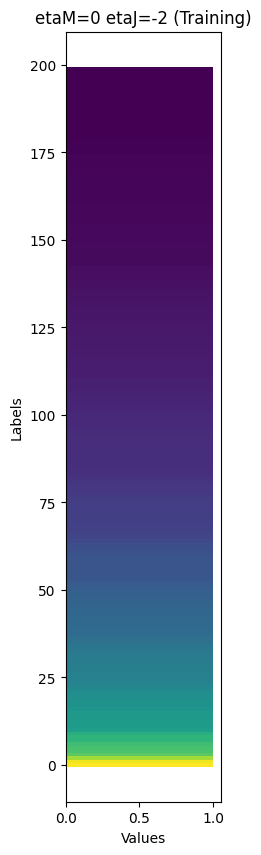

In [46]:
neuron_indices = np.arange(len(sorted_comp[0]))
width = np.ones_like(neuron_indices)
colors = plt.cm.viridis(sorted_comp[0])  # You can choose any colormap you prefer

# Create the horizontal bar plot
plt.figure(figsize=(2, 10))
bars = plt.barh(neuron_indices, width, height=1, color=colors)

# # Add color bar to indicate the mapping of color to values
# cbar = plt.colorbar(bars, orientation='vertical')
# cbar.set_label('Normalized Values')

plt.xlabel('Values')
plt.ylabel('Labels')
plt.title('etaM=0 etaJ=-2 (Training)')
plt.show()

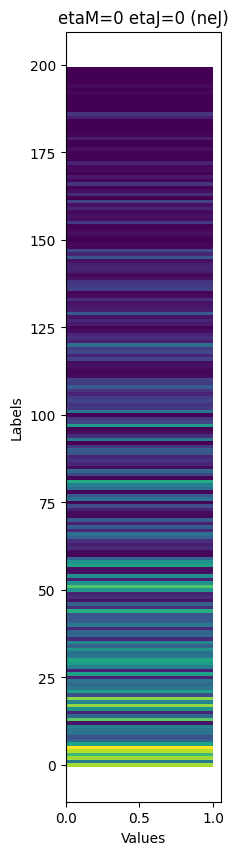

In [47]:
neuron_indices = np.arange(len(sorted_comp[1]))
width = np.ones_like(neuron_indices)
colors = plt.cm.viridis(sorted_comp[1])  # You can choose any colormap you prefer

# Create the horizontal bar plot
plt.figure(figsize=(2, 10))
bars = plt.barh(neuron_indices, width, height=1, color=colors)

# # Add color bar to indicate the mapping of color to values
# cbar = plt.colorbar(bars, orientation='vertical')
# cbar.set_label('Normalized Values')

plt.xlabel('Values')
plt.ylabel('Labels')
plt.title('etaM=0 etaJ=0 (neJ)')
plt.show()

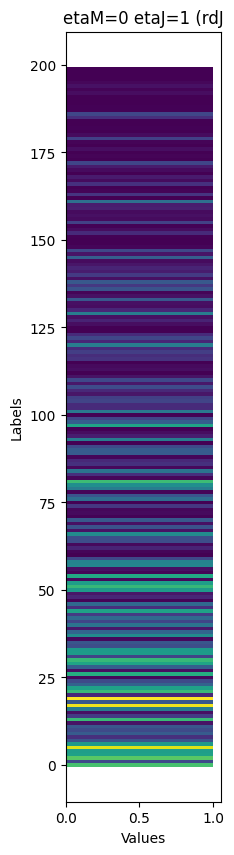

In [48]:
neuron_indices = np.arange(len(sorted_comp[2]))
width = np.ones_like(neuron_indices)
colors = plt.cm.viridis(sorted_comp[2])  # You can choose any colormap you prefer

# Create the horizontal bar plot
plt.figure(figsize=(2, 10))
bars = plt.barh(neuron_indices, width, height=1, color=colors)

# # Add color bar to indicate the mapping of color to values
# cbar = plt.colorbar(bars, orientation='vertical')
# cbar.set_label('Normalized Values')

plt.xlabel('Values')
plt.ylabel('Labels')
plt.title('etaM=0 etaJ=1 (rdJ')
plt.show()

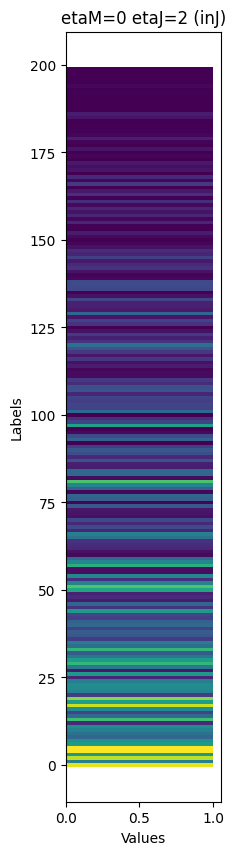

In [49]:
neuron_indices = np.arange(len(sorted_comp[3]))
width = np.ones_like(neuron_indices)
colors = plt.cm.viridis(sorted_comp[3])  # You can choose any colormap you prefer

# Create the horizontal bar plot
plt.figure(figsize=(2, 10))
bars = plt.barh(neuron_indices, width, height=1, color=colors)

# # Add color bar to indicate the mapping of color to values
# cbar = plt.colorbar(bars, orientation='vertical')
# cbar.set_label('Normalized Values')

plt.xlabel('Values')
plt.ylabel('Labels')
plt.title('etaM=0 etaJ=2 (inJ)')
plt.show()